<a href="https://colab.research.google.com/github/shaye440/MarkdownLearning/blob/master/modelForCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://awscdn.datafountain.cn/cometition_data2/Files/PengCheng2020/RSImage/baseline.zip

--2020-09-19 11:50:48--  https://awscdn.datafountain.cn/cometition_data2/Files/PengCheng2020/RSImage/baseline.zip
Resolving awscdn.datafountain.cn (awscdn.datafountain.cn)... 118.193.97.222, 118.193.97.223, 118.193.97.192, ...
Connecting to awscdn.datafountain.cn (awscdn.datafountain.cn)|118.193.97.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18872584 (18M) [application/zip]
Saving to: ‘baseline.zip.1’

baseline.zip.1      100%[===================>]  18.00M  6.19MB/s    in 2.9s    

2020-09-19 11:50:52 (6.19 MB/s) - ‘baseline.zip.1’ saved [18872584/18872584]



In [ ]:
!unzip 'baseline.zip'

Archive:  baseline.zip
replace baseline/dataloader.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from matplotlib import pyplot as plt
import skimage.io as io
from torch.utils.data import Dataset
from PIL import Image

#root = '/content/baseline/train'

class RSDataset(Dataset):
  def __init__(self, root, transforms):
    super(RSDataset,self).__init__()
    self.root = root
    self.transforms = transforms
    self.listFiles = []
    #my_files = os.listdir("/content/baseline/train")
    #print(my_files)
    imgs_root = os.listdir("/content/baseline/train/images")
    labels_root = os.listdir("/content/baseline/train/labels")
    for files in imgs_root:
      if "tif" in files:
          self.listFiles.append([self.root + '/images/' + files, self.root + '/labels/' + files[:-4]+'.png'])
    #print(self.listFiles)
  def __getitem__(self,index):
    x = Image.open(self.listFiles[index][0])
    x = self.transforms(x)
    y = Image.open(self.listFiles[index][1])
    y = self.transforms(y)
    return x, y
    
  def __len__(self):
    return len(self.listFiles)


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:70: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.int32, copy=False))


(<matplotlib.axes._subplots.AxesSubplot at 0x7f0e47a79fd0>,
 (-0.5, 255.5, 255.5, -0.5))

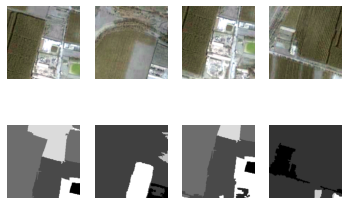

In [ ]:
import os
import torch
from  torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

transform = transforms.Compose([
            transforms.ToTensor()
        ])

dataset = RSDataset('/content/baseline/train',transforms=transform)

#dataset = ImageFolder('/content/data/dogcat_2',transform=transform)

dataloader = DataLoader(dataset,batch_size=4,shuffle=True,num_workers=1,drop_last=False)

dataiter = iter(dataloader)
imgs = next(dataiter)
imgs0 = imgs[0]
imgs1 = imgs[1]
imgs0 = imgs0.permute(0, 2, 3, 1)
imgs1 = imgs1.permute(0, 2, 3, 1)



plt.subplot(241),plt.imshow(imgs0[0]),plt.axis('off')
plt.subplot(242),plt.imshow(imgs0[1]),plt.axis('off')
plt.subplot(243),plt.imshow(imgs0[2]),plt.axis('off')
plt.subplot(244),plt.imshow(imgs0[3]),plt.axis('off')

plt.subplot(245),plt.imshow(imgs1[0][:,:,0],cmap='gray'),plt.axis('off')
plt.subplot(246),plt.imshow(imgs1[1][:,:,0],cmap='gray'),plt.axis('off')
plt.subplot(247),plt.imshow(imgs1[2][:,:,0],cmap='gray'),plt.axis('off')
plt.subplot(248),plt.imshow(imgs1[3][:,:,0],cmap='gray'),plt.axis('off')




In [ ]:
import torch
import torch.nn as nn
import torch.functional as F

class UNet(nn.Module):
    def __init__(self, input_nc, output_nc):
        super(UNet, self).__init__()
        self.in_conv1 = nn.Conv2d(input_nc, 64, kernel_size=3, stride=1, padding=1)
        self.in_conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.pooling1 = nn.MaxPool2d(2)
        self.conv1_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.pooling2 = nn.MaxPool2d(2)
        self.conv2_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.pooling3 = nn.MaxPool2d(2)
        self.conv3_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.pooling4 = nn.MaxPool2d(2)
        self.conv4_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.upsampling1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv5_1 = nn.Conv2d(1024, 256, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.upsampling2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv6_1 = nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1)
        self.conv6_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.upsampling3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv7_1 = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1)
        self.conv7_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.upsampling4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv8_1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv8_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.out_conv = nn.Conv2d(64, output_nc, kernel_size=1, stride=1, padding=0)

        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        self.bn512 = nn.BatchNorm2d(512)

        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        c1 = self.relu(self.bn64(self.in_conv1(input)))
        c2 = self.relu(self.bn64(self.in_conv2(c1)))

        e1_ = self.relu(self.bn128(self.conv1_1(self.pooling1(c2))))
        e1 = self.relu(self.bn128(self.conv1_2(e1_)))

        e2_ = self.relu(self.bn256(self.conv2_1(self.pooling1(e1))))
        e2 = self.relu(self.bn256(self.conv2_2(e2_)))

        e3_ = self.relu(self.bn512(self.conv3_1(self.pooling1(e2))))
        e3 = self.relu(self.bn512(self.conv3_2(e3_)))

        e4_ = self.relu(self.bn512(self.conv4_1(self.pooling1(e3))))
        e4 = self.relu(self.bn512(self.conv4_2(e4_)))

        d1_1 = self.upsampling1(e4)
        d1_2 = torch.cat([d1_1, e3], dim=1)
        d1_ = self.relu(self.bn256(self.conv5_1(d1_2)))
        d1 = self.relu(self.bn256(self.conv5_2(d1_)))

        d2_1 = self.upsampling1(d1)
        d2_2 = torch.cat([d2_1, e2], dim=1)
        d2_ = self.relu(self.bn128(self.conv6_1(d2_2)))
        d2 = self.relu(self.bn128(self.conv6_2(d2_)))

        d3_1 = self.upsampling1(d2)
        d3_2 = torch.cat([d3_1, e1], dim=1)
        d3_ = self.relu(self.bn64(self.conv7_1(d3_2)))
        d3 = self.relu(self.bn64(self.conv7_2(d3_)))

        d4_1 = self.upsampling1(d3)
        d4_2 = torch.cat([d4_1, c2], dim=1)
        d4_ = self.relu(self.bn64(self.conv8_1(d4_2)))
        d4 = self.relu(self.bn64(self.conv8_2(d4_)))

        output = self.sigmoid(self.out_conv(d4))

        return output


In [ ]:
import torch

net = UNet(3,1)
ce_loss = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(),lr = 0.001)

epoch = 5
batch_size = 1

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net.train()
for epoch in range(1,5+1):
  for batch_idx, (data, targets ) in enumerate(dataloader):
          #data = data.to(device)
          #data = data.double()
          optimizer.zero_grad()
          output = net(data)
          output = output.view(-1).float()
          targets = targets.view(-1).float()
          loss = ce_loss(output,targets)
          loss.backward()
          optimizer.step()
          
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(dataloader.dataset),
              100. * batch_idx / len(dataloader),loss.item()))
          

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:70: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.int32, copy=False))


Train Epoch: 1 [0/10 (0%)]	Loss: 223.740326
Train Epoch: 1 [4/10 (33%)]	Loss: 151.724625
Train Epoch: 1 [4/10 (67%)]	Loss: 88.265030


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:70: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.int32, copy=False))


Train Epoch: 2 [0/10 (0%)]	Loss: 18.649532
Train Epoch: 2 [4/10 (33%)]	Loss: -47.194401


KeyboardInterrupt: ignored